In [ ]:
#PIP INSTALLS:
!pip install wikipedia keybert sentence-transformers transformers spacy datasets evaluate matplotlib
!python -m spacy download en_core_web_sm

In [ ]:
#IMPORTS:
import wikipedia
from sentence_transformers import SentenceTransformer, util
import re
import json
import spacy
from keybert import KeyBERT
import re
from transformers import pipeline, AutoTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import precision_score, accuracy_score
from google.colab import drive, files
from datasets import load_dataset
from tqdm import tqdm
import evaluate
import matplotlib.pyplot as plt
from spacy.lang.en.stop_words import STOP_WORDS
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#DEFINITIONS:

# Common slang dictionary
SLANG_DICT = {
    "u": "you", "ur": "your", "r": "are", "y": "why",
    "wat": "what", "wats": "what is", "wanna": "want to",
    "gonna": "going to", "tho": "though", "pls": "please",
    "thx": "thanks", "lol": "", "omg": "oh my god",
    "idk": "I don't know", "btw": "by the way", "smh": "shaking my head",
    "bff": "best friend forever", "brb": "be right back", "tbh": "to be honest",
    "fyi": "for your information", "lmao": "laughing my ass off", "rofl": "rolling on the floor laughing",
    "ttyl": "talk to you later", "np": "no problem", "yolo": "you only live once",
    "fam": "family", "lit": "exciting or excellent", "savage": "ruthless or harsh",
    "slay": "to do something exceptionally well", "bae": "before anyone else", "cray": "crazy",
    "fomo": "fear of missing out", "swag": "style or coolness", "vibe": "mood or atmosphere",
    "tbh": "to be honest", "imo": "in my opinion", "srsly": "seriously", "jk": "just kidding",
    "ppl": "people", "wyd": "what you doing", "smexy": "sexy", "af": "as f*ck",
    "wth": "what the hell", "wtf": "what the f*ck", "asl": "age, sex, location",
    "ik": "I know", "ikr": "I know, right?", "lml": "laughing madly", "hmu": "hit me up",
    "mfw": "my face when", "fml": "f*ck my life", "yass": "yes"
}

def extract_keyword_spacy_keybert(question):
    doc = nlp(question)
    question_lower = question.lower()

    priority_entity_labels = ["PERSON", "ORG", "GPE", "FAC", "LOC"]
    named_entities = [ent.text for ent in doc.ents if ent.label_ in priority_entity_labels]

    if named_entities:
        return named_entities[0]

    noun_phrases = [chunk.text for chunk in doc.noun_chunks]

    keywords = kw_model.extract_keywords(question, top_n=3, stop_words='english')
    bert_keywords = [kw[0] for kw in keywords]


    candidates = list(dict.fromkeys(noun_phrases + bert_keywords))

    filtered_candidates = [
        c for c in candidates
        if c.lower() not in STOP_WORDS and len(c.strip()) > 2]


    filtered_candidates = sorted(filtered_candidates, key=lambda x: question_lower.find(x.lower()))

    return filtered_candidates[0] if filtered_candidates else question

def get_wikipedia_article(query):
    try:

        try:
            page = wikipedia.page(query, auto_suggest=False)
            print(f"Retrieved (exact match): {page.title}")
            return page.content
        except (wikipedia.DisambiguationError, wikipedia.PageError):
            pass


        search_results = wikipedia.search(query)
        if not search_results:
            print("No search results found.")
            return None


        for title in search_results:
            try:
                page = wikipedia.page(title)
                if "replica" not in page.title.lower():
                    print(f"Retrieved: {page.title}")
                    return page.content
            except (wikipedia.DisambiguationError, wikipedia.PageError):
                continue

        print("No valid Wikipedia page found.")
        return None

    except Exception as e:
        print(f"Error occurred: {e}")
        return None


def get_best_wikipedia_article(question, top_n=5):
    search_results = wikipedia.search(question, results=top_n)
    print("Candidates:", search_results)
    summaries = []
    titles = []
    for title in search_results:
        try:
            summary = wikipedia.summary(title, sentences=3)
            summaries.append(summary)
            titles.append(title)
        except wikipedia.exceptions.DisambiguationError:
            continue
        except wikipedia.exceptions.PageError:
            continue

    if not summaries:
        return None
    question_embedding = embedder.encode(question, convert_to_tensor=True)
    summary_embeddings = embedder.encode(summaries, convert_to_tensor=True)
    cosine_scores = util.cos_sim(question_embedding, summary_embeddings)

    best_idx = cosine_scores.argmax().item()
    best_title = titles[best_idx]
    best_page = wikipedia.page(best_title)

    print(f"Best match: {best_title}")
    return best_page.content

def expand_question(question):
    """Replace common slangs and shorthand in questions."""
    words = question.lower().split()
    expanded = [SLANG_DICT.get(w, w) for w in words]
    return ' '.join(expanded)

def clean_text(text):
    """Remove unwanted characters and normalize spacing."""
    text = re.sub(r'\[\d+\]', '', text)  # Remove references like [1]
    return re.sub(r'\s+', ' ', text).strip()

def chunk_text_by_tokens(text, max_tokens=450):
    """Split long text into chunks based on token length."""
    tokens = tokenizer.encode(text, add_special_tokens=False)
    chunks = [tokens[i:i+max_tokens] for i in range(0, len(tokens), max_tokens)]
    return [tokenizer.decode(chunk, skip_special_tokens=True) for chunk in chunks]

def chunk_text_with_stride(text, max_length=384, stride=128):
    inputs = tokenizer(text, return_overflowing_tokens=True, max_length=max_length, stride=stride, truncation=True, padding="max_length")
    return [tokenizer.decode(input_ids, skip_special_tokens=True) for input_ids in inputs["input_ids"]]


def rank_chunks_semantic(question, chunks, top_k=3):
    question_emb = embedder.encode(question, convert_to_tensor=True)
    chunk_embs = embedder.encode(chunks, convert_to_tensor=True)
    scores = util.cos_sim(question_emb, chunk_embs)[0]
    top_indices = scores.argsort(descending=True)[:top_k]
    return [chunks[i] for i in top_indices]

def rank_chunks_tfidf(question, chunks, top_k=3):
    """Rank text chunks based on TF-IDF similarity to the question."""
    vectorizer = TfidfVectorizer().fit([question] + chunks)
    vectors = vectorizer.transform([question] + chunks)
    scores = cosine_similarity(vectors[0:1], vectors[1:]).flatten()
    top_indices = scores.argsort()[-top_k:][::-1]
    return [chunks[i] for i in top_indices]

def is_valid_answer(answer_text, score, min_len=3, min_score=0.1):
    """Check if the answer is valid based on length and confidence."""
    return len(answer_text.strip()) >= min_len and score >= min_score

def get_best_answer(question, text_chunks):
    """Run QA model on ranked chunks and return best answer."""
    answers = []
    for chunk in text_chunks:
        try:
            result = qa_pipeline({'question': question, 'context': chunk})
            if is_valid_answer(result['answer'], result['score']):
                cleaned = re.sub(r'[^\w\s,.]', '', result['answer']).strip()
                answers.append((cleaned, result['score']))
        except Exception as e:
            logger.warning(f"QA failed on chunk: {e}")
    return max(answers, key=lambda x: x[1])[0] if answers else "No good answer found."

def answer_question(question, full_text):
    """Top-level QA function: cleans, expands, chunks, ranks, answers."""
    question_expanded = expand_question(question.lower())
    cleaned_text = clean_text(full_text)
    chunks = chunk_text_with_stride(cleaned_text)
    top_chunks = rank_chunks_semantic(question_expanded, chunks)
    return get_best_answer(question_expanded, top_chunks)

def is_short_answer(example, max_words=3):
    # Use the first answer in case there are multiple
    answer = example["answers"]["text"][0]
    return len(answer.strip().split()) <= max_words


def developPipelines():
    qa_pipelines = []
    for count in range(0, 21):
        #path = f"/content/drive/My Drive/Distil-BERT/QA/Model{count}"
        path = f"/content/drive/My Drive/Colab Notebooks/Distil-BERT/QA/Model{count}"
        qa = pipeline("question-answering", model=path, tokenizer=path)
        qa_pipelines.append(qa)
    return qa_pipelines

qa_pipelines = developPipelines()


Device set to use cpu


In [ ]:
metrics = []
# Load the validation set
dataset = load_dataset("squad", split="validation")
dataset = dataset.filter(is_short_answer)
dataset = dataset.shuffle(seed=42).select(range(100))
for count in range(0, 20):
    nlp = spacy.load("en_core_web_sm")
    kw_model = KeyBERT()
    embedder = SentenceTransformer('all-MiniLM-L6-v2')
    qa_pipeline = qa_pipelines[count]
    #tokenizer = AutoTokenizer.from_pretrained("/content/drive/My Drive/Distil-BERT/QA/Model1")
    tokenizer = AutoTokenizer.from_pretrained("/content/drive/My Drive/Colab Notebooks/Distil-BERT/QA/Model1")
    predictions = []
    references = []

    for item in tqdm(dataset):
        question = item["question"]
        context = item["context"]
        ground_truths = item["answers"]["text"]

        #Run model
        predicted_answer = answer_question(question, context)

        #Save predictions and references
        predictions.append({
            "id": item["id"],
            "prediction_text": predicted_answer
        })

        references.append({
            "id": item["id"],
            "answers": {
                "answer_start": item["answers"]["answer_start"],
                "text": ground_truths
            }
        })
    squad_metric = evaluate.load("squad")

    results = squad_metric.compute(predictions=predictions, references=references)

    #Create binary labels: 1 if prediction has F1 > 0, else 0
    binary_preds = []
    binary_refs = []

    for pred, ref in zip(predictions, references):
        pred_text = pred["prediction_text"]
        gold_texts = ref["answers"]["text"]

        #Match if exact or partial overlap
        matched = any(pred_text.strip().lower() in gt.lower() or gt.lower() in pred_text.strip().lower() for gt in gold_texts)

        binary_preds.append(1 if matched else 0)
        binary_refs.append(1)  #All references are positives

    #Accuracy: how many were correct
    acc = accuracy_score(binary_refs, binary_preds)
    list1 = [results['exact_match'], results['f1'], acc]
    metrics.append(list1)


Device set to use cpu


Enter your question: When did Ronaldo start the siu?
🔎 Candidates: ['Cristiano Ronaldo', 'Ronaldo', 'Ronaldo (Brazilian footballer)', 'Messi–Ronaldo rivalry', 'List of career achievements by Cristiano Ronaldo']
✅ Best match: Cristiano Ronaldo
Q: When did Ronaldo start the siu?
A: 2023


100%|██████████| 100/100 [00:50<00:00,  1.97it/s]


In [ ]:
i = 0
for row in metrics:
    i += 1
    print(f"Evaluation Results : Model {i}:")
    print(f"Exact Match (EM): {row[0]:.2f}")
    print(f"F1 Score: {row[1]:.2f}")
    print(f"Accuracy: {row[2]:.2f}")

Evaluation Results per Model:
Exact Match (EM): 72.00
F1 Score: 76.11
Accuracy: 0.77


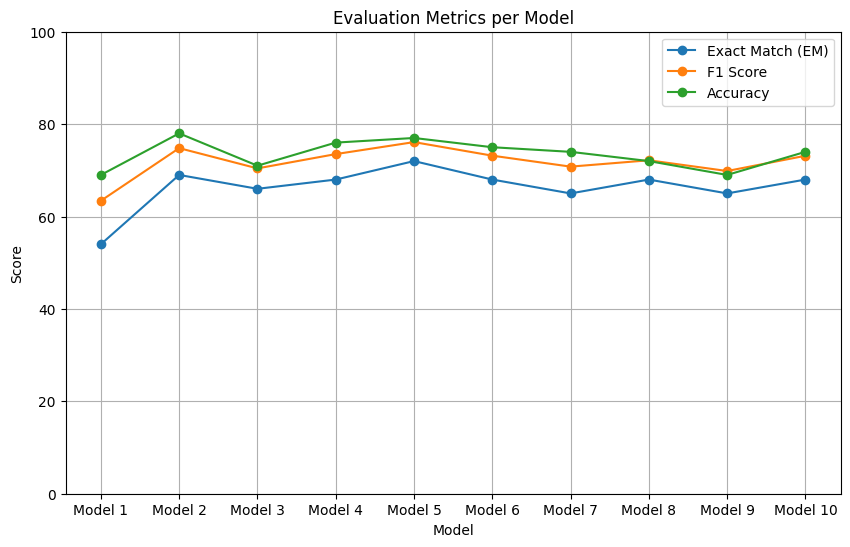

In [ ]:
# Transpose metrics
em_scores = [row[0] for row in metrics]
f1_scores = [row[1] for row in metrics]
accuracy_scores = [row[2] * 100 for row in metrics]

# Numeric x-axis
x = list(range(len(metrics)))
model_labels = [f"Model {i+1}" for i in x]

# Compute average for each model
average_scores = [(em + f1 + acc) / 3 for em, f1, acc in zip(em_scores, f1_scores, accuracy_scores)]
best_model_index = average_scores.index(max(average_scores))
best_model_label = model_labels[best_model_index]

# Plot
plt.figure(figsize=(12, 6))
plt.plot(x, em_scores, label="Exact Match (EM)", marker='o')
plt.plot(x, f1_scores, label="F1 Score", marker='o')
plt.plot(x, accuracy_scores, label="Accuracy", marker='o')

# Annotate max values
def annotate_max(values, label):
    idx = values.index(max(values))
    plt.annotate(f"Max {label}: {max(values):.2f}\n({model_labels[idx]})",
                 (x[idx], values[idx]),
                 textcoords="offset points",
                 xytext=(0,10), ha='center',
                 fontsize=9, color='red', fontweight='bold')

annotate_max(em_scores, "EM")
annotate_max(f1_scores, "F1")
annotate_max(accuracy_scores, "Accuracy")

# Highlight best overall model
plt.axvline(x=best_model_index, color='gray', linestyle='--', alpha=0.5)
plt.text(best_model_index, 95, f"Best Avg: {best_model_label}\n({average_scores[best_model_index]:.2f})",
         ha='center', fontsize=9, bbox=dict(facecolor='yellow', alpha=0.3))

# Finalize plot
plt.xticks(ticks=x, labels=model_labels, rotation=45)
plt.title("Evaluation Metrics per Model")
plt.xlabel("Model")
plt.ylabel("Score")
plt.ylim(0, 100)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
